In [15]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt

In [16]:
# svd funciton
def condition(S):
    condition_number = S[0] / S[-1]
    print("\nCondition Number:", condition_number)
    return condition_number

def ratios(S):
    singular_value_ratios = S[:-1] / S[1:]
    print("\nSingular Value Ratios:", singular_value_ratios[:10])
    return singular_value_ratios

def effective_rank(singular_values, threshold=1e-3):
    ratios = singular_values / singular_values[0]
    return torch.sum(ratios > threshold)

def frobenius(S):
    frobenius_norm_svd = torch.sqrt(torch.sum(S**2))
    print("Frobenius Norm (from SVD):", frobenius_norm_svd)

#Energy Captured by Top k Singular Values
def energy_captured(singular_values, i,k=256):
    energy_top_k = torch.sum(singular_values[:i]**2)
    total_energy = torch.sum(singular_values[:k]**2)
    return energy_top_k / total_energy

def evaluate_s(S):
    condition(S)
    ratios(S)
    effective_rank(S)
    frobenius(S)
    energy_captured(S, 20)

def svd(data):
    U, S, V = torch.svd(torch.tensor(data))
    return S
    
def max_svg(data_list):
    body_datas = None
    rot_body_datas = None
    global_datas = None

    for name in data_list:
        
        body_data = np.load("body_"+name+"_feature.npy")
        global_data = np.load("global_"+name+"_feature.npy")
        
        if body_datas is None:
            body_datas = body_data
            global_datas = global_data
        else:
            body_datas = np.concatenate((body_datas,body_data),axis=0)
            global_datas = np.concatenate((global_datas,global_data),axis=0)
    body_s,global_s = svd(body_datas), svd(global_datas)
    return body_s,global_s

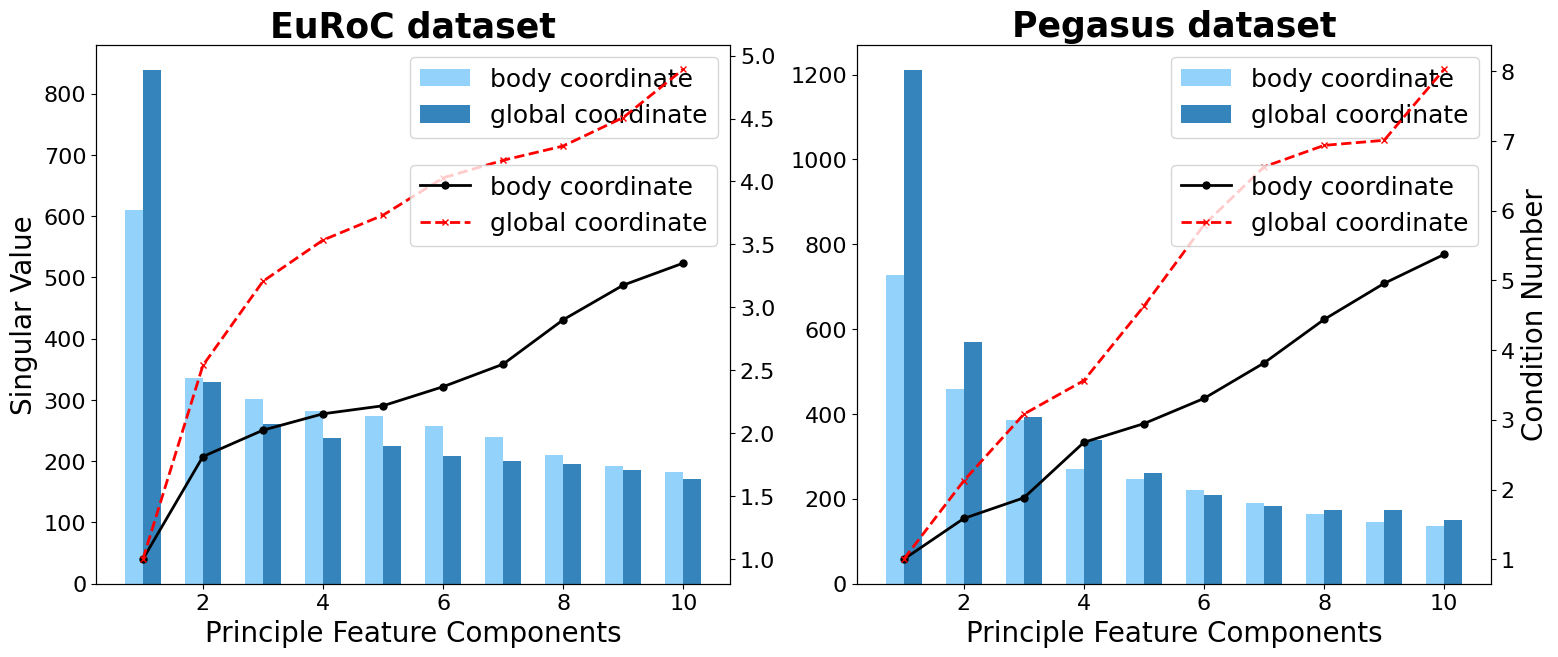

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(18, 7))
def visual(data_list, id=0,data_name = "EuRoC dataset"):
    
    ax2 = axs[id]  # Select subplot; make sure plot_index is either 0 or 1
    
    body_s,global_s = max_svg(data_list)
    sorted_body_s, body_indices = torch.sort(body_s, descending=True)
    sorted_global_s, global_indices = torch.sort(global_s, descending=True)
   
    b = []
    r = []
    g = []
    for i in range(1,11):
        b.append(sorted_body_s[0].item()/sorted_body_s[i].item())
        g.append(sorted_global_s[0].item()/sorted_global_s[i].item())
    plt.figure(figsize=(12, 6)) 
    
    y1 = np.array(sorted_body_s[0]/sorted_body_s[:10])
    y2 = np.array(sorted_global_s[0]/sorted_global_s[:10]) 
    
    bar_values1 = sorted_body_s[:10] 
    bar_values2 = sorted_global_s[:10]


    x = list(range(1, 11)) 

    ax1 = ax2.twinx()


    bar_width = 0.3
    indices = [i - bar_width/2 for i in x]  
    indices2 = [i + bar_width/2 for i in x] 


    ax2.bar(indices, bar_values1,color="lightskyblue", width=bar_width, alpha=0.9, label='body coordinate')
    ax2.bar(indices2, bar_values2, width=bar_width, alpha=0.9, label='global coordinate')
    

    ax1.plot(x, y1, marker='o', linestyle='-', color='black', label='body coordinate', linewidth=2, markersize=5)
    ax1.plot(x, y2, marker='x', linestyle='--', color='r', label='global coordinate', linewidth=2, markersize=5)

    if id == 1:
        ax1.set_ylabel('Condition Number', fontsize=20)
    if id == 0:
        ax2.set_ylabel('Singular Value', fontsize=20) 
    ax2.set_xlabel('Principle Feature Components', fontsize=20)
    ax2.set_title(data_name, fontsize=25, fontweight='bold')


    ax1.legend(loc='upper left', bbox_to_anchor=(0.475, 0.8),fontsize=18)
    ax2.legend(fontsize=18) 
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax2.tick_params(axis='both', which='major', labelsize=16)

    # Save the entire figure to an SVG file
    plt.tight_layout()
    fig.savefig(f"svd.pdf", bbox_inches='tight')

    # plt.rcParams['text.color'] = 'white'
    # plt.rcParams['axes.facecolor'] = 'none'
    # plt.rcParams['axes.edgecolor'] = 'white'
    # plt.rcParams['xtick.color'] = 'white'
    # plt.rcParams['ytick.color'] = 'white'
    # plt.rcParams['figure.facecolor'] = 'none'

visual(["MH_02_easy", "MH_04_difficult", "V1_03_difficult","V2_02_medium","V1_01_easy"],id = 0,data_name = "EuRoC dataset")
visual(["traj2","traj3","traj6"],id = 1,data_name = "Pegasus dataset")

(122704, 17)
(122704, 17)
14.285689111065018
20.21806674115161
(156933, 17)
(156933, 17)
30.951270940110106
83.14829124634991


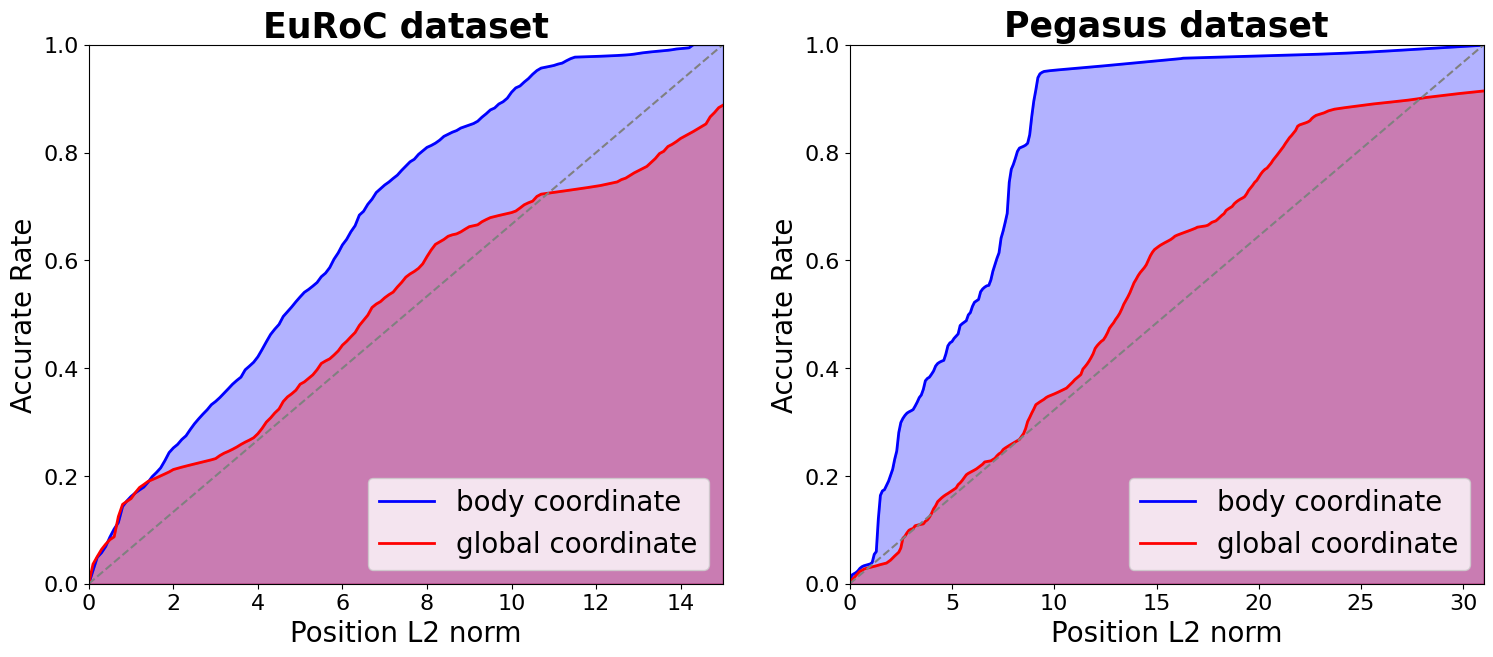

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(18, 7))
def visual_auc(body_accs, global_accs, threshold_list, data_name=None, plot_index=0):
    ax = axs[plot_index]  # Select subplot; make sure plot_index is either 0 or 1
    ax.plot(threshold_list, body_accs, color='blue', lw=2, label='body coordinate')
    ax.plot(threshold_list, global_accs, color='red', lw=2, label='global coordinate')
    ax.fill_between(threshold_list, body_accs, alpha=0.3, color='blue')
    ax.fill_between(threshold_list, global_accs, alpha=0.3, color='red')
    ax.plot([0, threshold_list[-1]], [0, 1], color='grey', linestyle='--')
    ax.set_xlabel('Position L2 norm', fontsize=20)
    ax.set_ylabel('Accurate Rate', fontsize=20)
    ax.set_xlim(left=0, right=threshold_list[-1])
    ax.set_ylim(bottom=0, top=1)
    ax.set_title("EuRoC Dataset" if not data_name else f"{data_name}",fontsize=25, fontweight='bold')
    ax.legend(loc="lower right", fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=16)

    # Save the entire figure to an SVG file
    # plt.tight_layout()
    fig.savefig(f"auc.pdf", bbox_inches='tight')

def calculate_accurray(data, error_end = 15,error_step=0.1):
    pred_pos = data[:,1:4]
    gt_pos = data[:,4:7]

    error = np.linalg.norm(gt_pos - pred_pos,axis=1)
    print(max(error))
    error_start = 0
    error_end = error_end + 0.1
    number = error.shape[0]
    acc_list = []
    threshold_list = np.arange(0, error_end, error_step)
    for thres in threshold_list:
        corrects = np.where(error < thres)[0]
        correct_num = corrects.shape[0]
        acc = correct_num / number
        acc_list.append(acc)
    return acc_list, threshold_list

def cat_trajs(data_list):
    datas = None
    for i,data_name in enumerate(data_list): 
        data_path = os.path.join("/Users/can/Downloads/plot_auc/",data_name+"plot_auc.csv")
        data = np.loadtxt(data_path, delimiter=" ")
        if datas is None:
            datas = data
        else:
            datas = np.concatenate((datas,data), axis=0)
    print(datas.shape)
    return datas

datas = cat_trajs(["MH_02_easy", "MH_04_difficult","V1_03_difficult","V1_01_easy","V2_02_medium"]) 
datas_global = cat_trajs(["global_MH_02_easy", "global_MH_04_difficult","global_V1_03_difficult","global_V1_01_easy","global_V2_02_medium"]) 
body_acc, threshold_list = calculate_accurray(datas,error_end=15)
global_acc, _ = calculate_accurray(datas_global,error_end=15)


datas_2 = cat_trajs(["traj2", "traj3","traj6"]) 
datas_global_2 = cat_trajs(["global_traj2", "global_traj3","global_traj6"]) 
body_acc_2, threshold_list_2 = calculate_accurray(datas_2,error_end=31)
global_acc_2, _ = calculate_accurray(datas_global_2,error_end=31)
visual_auc(body_acc, global_acc, threshold_list, data_name="EuRoC dataset", plot_index=0)
visual_auc(body_acc_2, global_acc_2, threshold_list_2, data_name="Pegasus dataset", plot_index=1)



In [22]:
from sklearn.manifold import TSNE

def dataloader(data_list):
    body_datas = None
    rot_body_datas = None
    global_datas = None

    for name in data_list:
        
        body_data = np.load("body_"+name+"_feature.npy")
        global_data = np.load("global_"+name+"_feature.npy")
        
        if body_datas is None:
            body_datas = body_data
            global_datas = global_data
        else:
            body_datas = np.concatenate((body_datas,body_data),axis=0)
            global_datas = np.concatenate((global_datas,global_data),axis=0)
    return body_datas, global_datas
body_datas, global_datas = dataloader(["traj2","traj3","traj6"])


In [ ]:
activations = global_datas.reshape(global_datas.shape[0],-1)
tsne = TSNE(n_components=2)
global_activations_tsne = tsne.fit_transform(activations)



body_activations = body_datas.reshape(body_datas.shape[0],-1)
body_tsne = TSNE(n_components=2)
body_activations_tsne = body_tsne.fit_transform(body_activations)

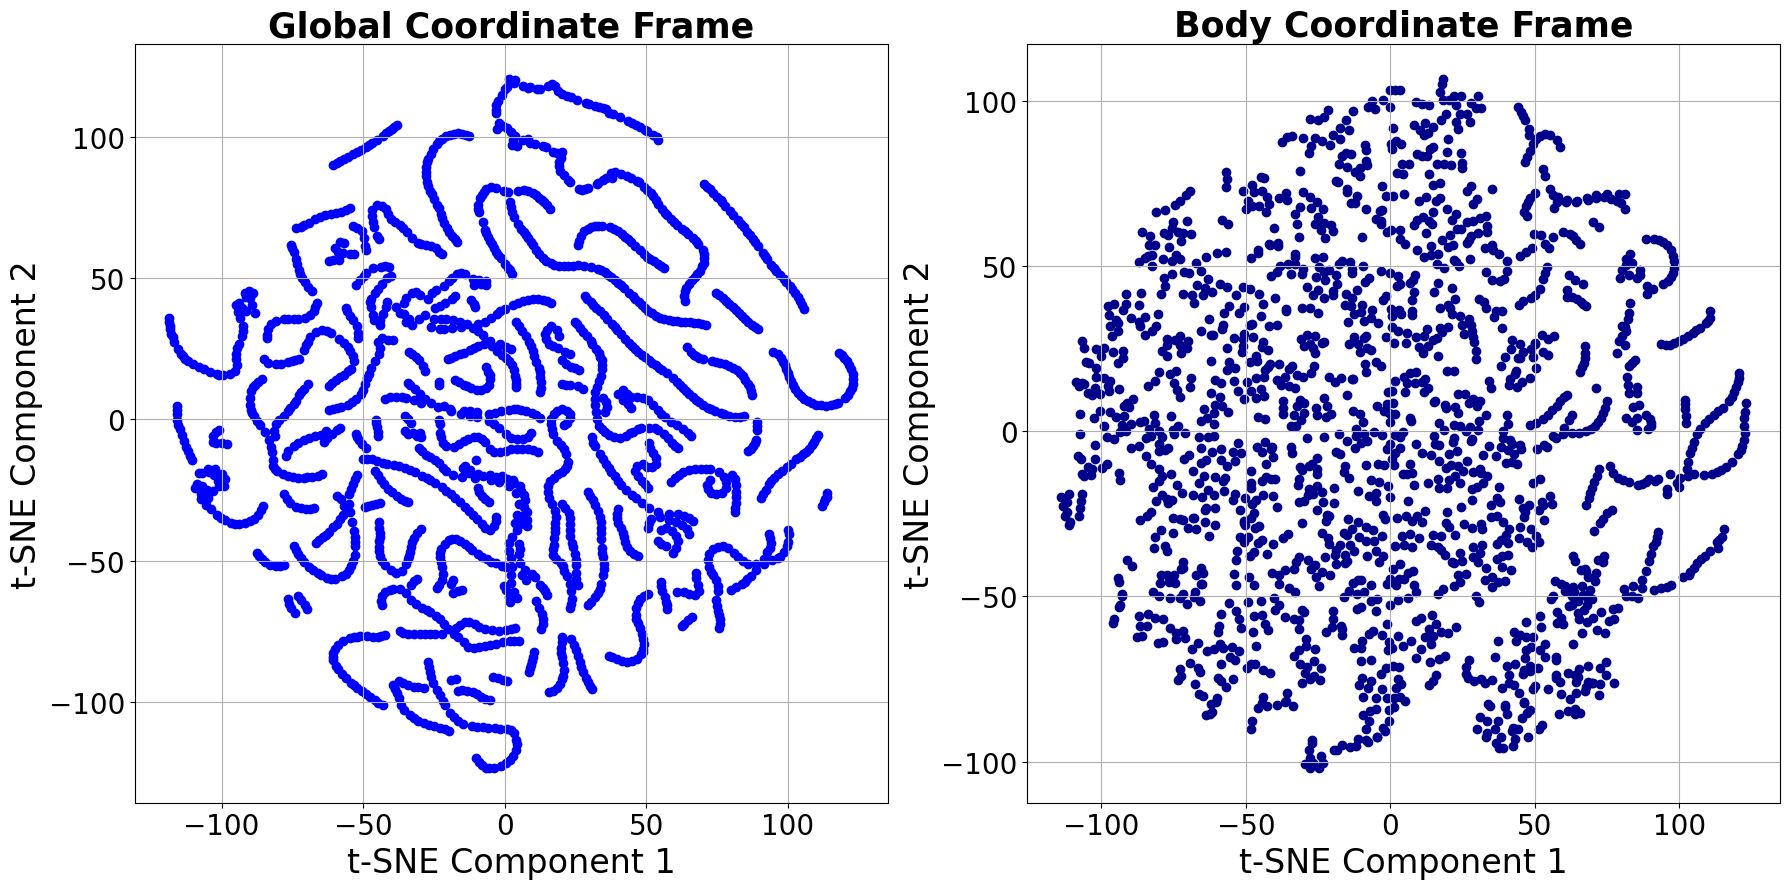

In [23]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np


# Set global style for the plots
# plt.style.use('dark_background')
# plt.rcParams['text.color'] = 'white'
# plt.rcParams['axes.labelcolor'] = 'white'
# plt.rcParams['xtick.color'] = 'white'
# plt.rcParams['ytick.color'] = 'white'
# plt.rcParams['axes.facecolor'] = 'none'
# plt.rcParams['figure.facecolor'] = 'none'
plt.style.use('default')
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

fig, axs = plt.subplots(1, 2, figsize=(18, 9))  # Create two subplots side by side

# Global Coordinate Frame plot
axs[0].scatter(
    global_activations_tsne[::10, 0],
    global_activations_tsne[::10, 1],
    color="blue"
)
axs[0].set_xlabel('t-SNE Component 1',fontsize=24)
axs[0].set_ylabel('t-SNE Component 2',fontsize=24)
axs[0].set_title("Global Coordinate Frame",fontsize=25, fontweight='bold')
axs[0].grid(True)

# Body Coordinate Frame plot
axs[1].scatter(
    body_activations_tsne[::10, 0],
    body_activations_tsne[::10, 1],
    color="darkblue"
)
axs[1].set_xlabel('t-SNE Component 1',fontsize=24)
axs[1].set_ylabel('t-SNE Component 2',fontsize=24)
axs[1].set_title("Body Coordinate Frame",fontsize=25, fontweight='bold')
axs[1].grid(True)

plt.tight_layout()
plt.savefig("tsne.pdf", format='pdf', bbox_inches='tight')

plt.show()
